In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
with open('homework4_spikes.npz', 'rb') as loadfile:
    spike_times = np.load(loadfile, allow_pickle=True)['spike_times']

with open('homework4_metadata.npy', 'rb') as loadfile:
    metadata = np.load(loadfile)
    time_touch_held = metadata['time_touch_held'] # target onset times for each trial
    time_go_cue = metadata['time_go_cue'] # go cue time for each trial
    time_target_acquired = metadata['time_target_acquired'] # time the target was touched
    trial_reach_target = metadata['trial_reach_target'] # index of reach target for each trial (0 through 7)
        # note that I've "fixed" the reach targets to be 0-7 rather than 1-8
    target_locations = metadata['target_locations'] # x,y location of each target
    target_angles = metadata['target_angles'] # angle of each target


In [3]:
# Verify that there are in fact two different plan period durations
np.unique(time_go_cue - time_touch_held)

array([ 755, 1005])

In [4]:
def extract_plan_spikes(window_length=None, 
                        start_offset=None):
    # Return a matrix of spike counts in the plan window.
    # - The default plan window is defined as the time between
    #   time_touch_held and time_go_cue for each trial. NOTE:
    #   not all trials have the same duration!!!
    # - If a "window_length" is specified, return the number
    #   of spikes in the window of that duration. Return -1
    #   if the available plan period is too short for the window
    #   (for example, window_length=1000 but the trial plan
    #   period is just 755 ms). 
    # - If a "start_offset" is specified, return the number of
    #   spikes in the window defined as starting "start_offset"
    #   ms after the time_touch_held. (Use either time_go_cue
    #   or the optional window_length to determine window end.)
    #   If start_offset is so large that it extends past the
    #   time_go_cue, return -1.
    
    if start_offset:
        trial_starts = time_touch_held + start_offset
    else:
        trial_starts = time_touch_held
    
    plan_spikes = []   
    for tx, trialSpikes in enumerate(spike_times):
        if window_length:
            trial_end = trial_starts[tx] + window_length
        else:
            trial_end = time_go_cue[tx]
        
        if (trial_end < trial_starts[tx]) or (trial_end > time_go_cue[tx]):
                plan_spikes.append(-np.ones(len(trialSpikes)))
        else:
            plan_spikes.append(
                np.array([np.sum((st > trial_starts[tx]) & 
                        (st < trial_end)) for st in trialSpikes]))
    return np.array(plan_spikes) # will be 1127 x 190 (number of trials by number of neurons)

In [5]:
plan_spikes = extract_plan_spikes()

In [6]:
# select the 755 ms plan period trials for testing
short_trials = (time_go_cue - time_touch_held) == 755 # boolean array

training_trials = [] # will be 8 lists of trials
test_trials = [] # all the leftovers
for c in range(8): # reach targets go from 0 to 7
    target_trials = np.argwhere(short_trials & (trial_reach_target==c)).squeeze()
    # randomly select 25 training trials per direction
    random_training_trials = np.random.choice(target_trials, 25, replace=False)
    training_trials.append(random_training_trials)
    remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)
    
    test_trials.extend(remaining_test_trials)


In [7]:
# Calculate the mean spike counts per neuron for each target
num_neurons = plan_spikes.shape[1]
mean_spike_counts = np.zeros((num_neurons, 8))
for c in range(8):
    mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)


In [8]:
def multivariate_poisson_logpdf(mu, x, mean_eps=0.01): 
    # assume mu is (N,) and x is (d,N)
    mu2 = mu
    mu2[np.argwhere(mu < mean_eps)] = mean_eps
    return np.sum(x * np.log(mu2) - mu2, axis=1)

In [9]:
# Calculate probability for each target and each test trial
poisson_likelihood = np.zeros((len(test_trials), 8))    
for c in range(8):
    m = mean_spike_counts[:,c]
    poisson_likelihood[:,c] = \
        multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])


In [10]:
correct_targets = trial_reach_target[test_trials] # correct target for each trial
decoded_targets = np.argmax(poisson_likelihood,axis=1) # decoded target is just the max index
print('Poisson Correct: ', np.mean(correct_targets==decoded_targets))
print('({} test trials)'.format(len(test_trials)))

Poisson Correct:  0.9478021978021978
(364 test trials)


In [12]:
decode_perf = []
for plan_window in np.arange(50,800,50): # (this goes to 750!!!)
    plan_spikes = extract_plan_spikes(window_length=plan_window)
    decode_perf.append([])
    
    # Randomly choose training and test data 25 times
    for i in range(50): 

        training_trials = [] # will be 8 lists of trials
        test_trials = [] # all the leftovers
        for c in range(8): # reach targets go from 0 to 7
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # randomly select 25 training trials per direction
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)

        num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)

        poisson_likelihood = np.zeros((len(test_trials), 8))    
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])
            
        correct_targets = trial_reach_target[test_trials] # correct target for each trial
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # decoded target is just the max index
                
        # Fill in code here to 
        #  1) randomly select training and test trials
        #  2) calculate mean spike counts using training data
        #  3) calculate target likelihoods for test data
        #  4) decode by picking the most likely target
        
        # Assuming that you define the variables "correct_targets"
        #  and "decoded_targets", the follow line calculates
        #  the decoding performance for this iteration
        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convert to a numpy array

[Text(0.5, 0, 'Plan Window Duration'), Text(0, 0.5, 'Decode Accuracy')]

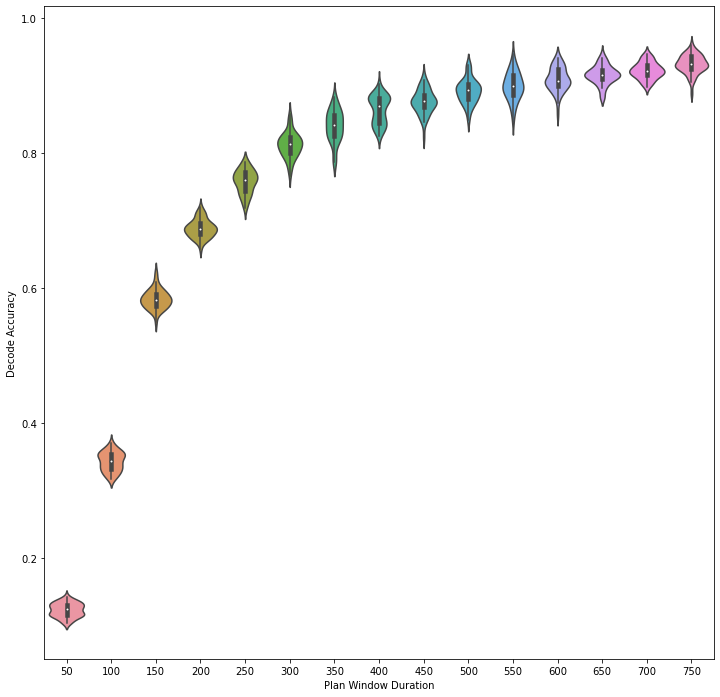

In [14]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, 
                              columns=np.arange(50,800,50)), figsize=(12,12))
ax.set(xlabel='Plan Window Duration', ylabel='Decode Accuracy')
